In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
from utility import *
from unfolding import *
rng = np.random.default_rng()

In [2]:
recon_table, true_table, weights = read_neutrino_simulations1(flavor='nu_e')

weights = weights * 11 #11 years

true_zenith = np.cos(true_table['zenith'].to_numpy())
recon_zenith = np.cos(recon_table['zenith'].to_numpy())
true_energy = np.log10(true_table['energy'].to_numpy())
recon_energy = np.log10(recon_table['energy'].to_numpy())

In [3]:
RANGE_START = 2.6
RANGE_END = 7
recon_bin_zenith = 4
true_bin_zenith = 4
recon_bin_energy = 28
true_bin_energy = 22
#recon_bin_energy = [2, 2.2, 2.4, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9, 2.95, 3, 3.05, 3.1, 3.15, 3.2, 3.25, 3.3, 3.35, 3.4, 3.45, 3.5, 3.55, 3.6, 3.65, 3.7, 3.75, 3.8, 3.85, 3.9, 3.95, 4, 4.15, 4.3, 4.45, 4.6, 4.75, 4.9, 5.05, 5.2, 5.35, 5.5, 5.9, 6.3, 6.7, 7.1, 7.5, 7.9, 8.1]
#true_bin_energy = [2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9, 2.95, 3, 3.05, 3.1, 3.15, 3.2, 3.25, 3.3, 3.35, 3.4, 3.45, 3.5, 3.55, 3.6, 3.65, 3.7, 3.75, 3.8, 3.85, 3.9, 3.95, 4, 4.15, 4.3, 4.45, 4.6, 4.75, 4.9, 5.05, 5.2, 5.35, 5.5, 5.9, 6.3, 6.7, 7.1]

recon_bin_zenith_count = len(recon_bin_zenith) - 1 if isinstance(recon_bin_zenith, list) else recon_bin_zenith
true_bin_zenith_count = len(true_bin_zenith) - 1 if isinstance(true_bin_zenith, list) else true_bin_zenith
recon_bin_energy_count = len(recon_bin_energy) - 1 if isinstance(recon_bin_energy, list) else recon_bin_energy
true_bin_energy_count = len(true_bin_energy) - 1 if isinstance(true_bin_energy, list) else true_bin_energy

#trim it up
trimming_cond = (true_energy > RANGE_START) & (true_energy < RANGE_END)
weights = weights[trimming_cond]
true_energy = true_energy[trimming_cond]
recon_energy = recon_energy[trimming_cond]
true_zenith = true_zenith[trimming_cond]
recon_zenith = recon_zenith[trimming_cond]
print(np.max(recon_energy))

7.594188341395917


In [4]:
#x will be energy, y will be zenith
recon_binned, xedges_recon, yedges_recon = np.histogram2d(recon_energy, recon_zenith, bins=(recon_bin_energy, recon_bin_zenith), weights=weights)
true_binned, xedges_true, yedges_true = np.histogram2d(true_energy, true_zenith, bins=(true_bin_energy, true_bin_zenith), weights=weights)

#alpha and acceptance error 
trimming_cond2 = (recon_energy > RANGE_START) & (recon_energy < RANGE_END)
weights_trimmed = weights[trimming_cond2]
true_energy_trimmed = true_energy[trimming_cond2]
recon_energy_trimmed = recon_energy[trimming_cond2]
true_zenith_trimmed = true_zenith[trimming_cond2]
recon_zenith_trimmed = recon_zenith[trimming_cond2]
recon_binned_trimmed = np.histogram2d(recon_energy_trimmed, recon_zenith_trimmed, bins=(true_bin_energy, true_bin_zenith), weights=weights_trimmed)[0]

In [ ]:
#compute A Matrix
A = np.histogramdd((recon_energy, true_energy, recon_zenith, true_zenith), bins=(recon_bin_energy, true_bin_energy, recon_bin_zenith, true_bin_zenith), weights=weights)[0]
# Normalize data, it must be the full set of true data, not trimmed down at all
#true_binned_full = np.histogram2d(true_energy_full, true_zenith_full, bins=(true_bin_energy, true_bin_zenith), weights=weights)[0]
for i in range(len(A)):
    for j in range(len(true_binned)):
        A[i][j] /= true_binned[j] + 1e-12
#alpha for acceptance error
alpha = np.sum(np.sum(A, axis=2), axis=0)
print(alpha.shape)

#writeAMatrix(A, alpha, '/home/colton/school/REU_2025/code/AMatrix_Data_Zelong.h5')
A, alpha = readAMatrix('/home/colton/school/REU_2025/code/AMatrix_Data_Zheyang.h5')
# print(A[:].shape)

In [6]:
#flat_recon_bins = recon_binned.flatten()
#recon_binned_shifted, xedges_recon_shifted, yedges_recon_shifted = np.histogram2d(recon_energy_trimmed + 100, recon_zenith_trimmed, bins=(true_bin_energy, true_bin_zenith), weights=weights_trimmed)
#flat_recon_bins = recon_binned_shifted.flatten()
flat_recon_bins = recon_binned_trimmed.flatten()
#flat_A = A.transpose(0, 2, 1, 3).reshape(recon_bin_energy_count * recon_bin_zenith_count, true_bin_energy_count * true_bin_zenith_count)
flat_A = A.transpose(0, 2, 1, 3).reshape(true_bin_energy_count * true_bin_zenith_count, true_bin_energy_count * true_bin_zenith_count)
flat_alpha = alpha.flatten()
print(flat_alpha)

[0.90943225 0.8728406  0.90170648 0.90697946 0.99761064 0.99864464
 0.99968595 1.         1.00011095 1.         0.9999     1.
 0.99990877 0.99981516 1.00008474 1.         0.9999462  1.00000325
 0.9997917  1.         1.00018803 0.99986868 1.00013405 0.99990411
 1.00000686 1.00013607 1.00010914 0.99991477 1.00013954 0.99988539
 1.00009299 1.00015184 0.99990938 1.00025402 0.99988317 1.00010841
 0.99946218 0.99965898 1.00024233 0.99970119 1.00156731 1.00114323
 1.00009824 1.0001134  1.00000039 0.99989013 0.99995929 1.00002246
 0.99999569 1.00021034 1.00019754 1.00053932 0.99941683 1.
 1.00033218 0.99985439 1.00092834 0.99974546 0.9998437  1.00030067
 1.         1.00033411 0.99967049 0.99994396 1.         1.00014313
 1.00091892 1.00047677 1.         0.99998236 0.99995148 1.
 1.         1.00003129 0.99590667 1.         1.         1.
 1.00488087 1.         1.         0.99963914 1.00007722 0.99988557
 0.92108014 0.90061098 0.87854298 0.91149921]


8


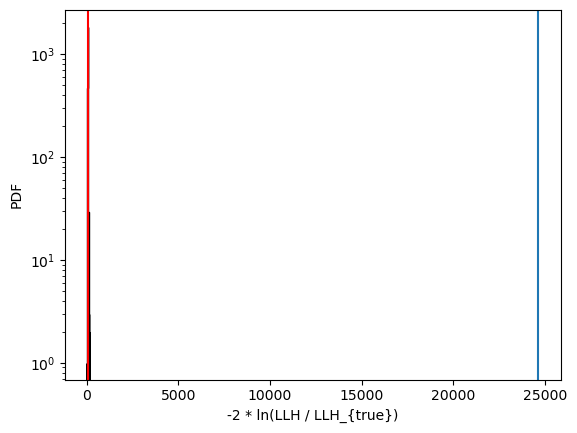

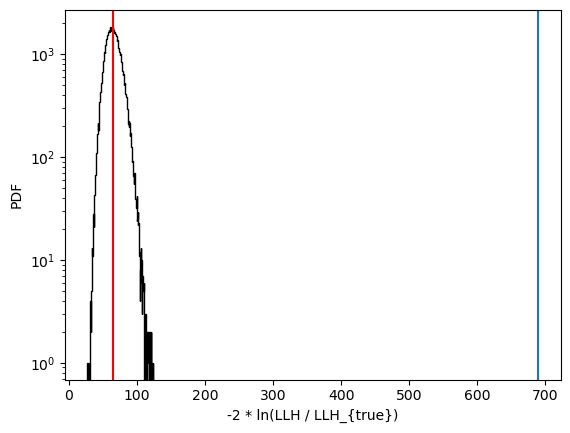

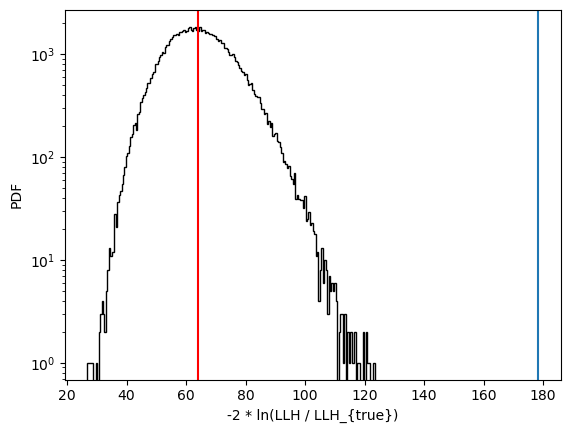

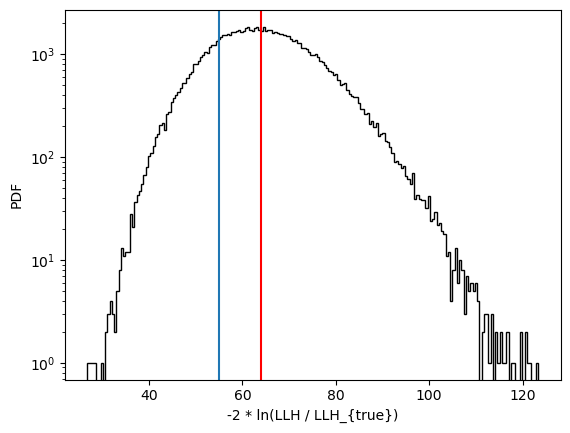

In [7]:
#Implementation of the R-L algorithm
unfolded = np.array([sum(weights) / (true_bin_energy_count * true_bin_zenith_count)] * (true_bin_energy_count * true_bin_zenith_count)) #starting with uniform dist

sampled_recon = [cal_llh(rng.poisson(flat_recon_bins), flat_recon_bins) for _ in range(100000)]
sampled_median = np.median(sampled_recon)
iter_count = 0
N_iter = np.matmul(flat_A, unfolded)
llh = cal_llh(flat_recon_bins, N_iter)

while llh > sampled_median:
    d_k = np.matmul(flat_A, unfolded)
    ratio = flat_recon_bins / (d_k + 1e-12)  # avoid division by zero
    unfolded = unfolded * (flat_A.T @ ratio) / (flat_alpha + 1e-12)

    llh = cal_llh(flat_recon_bins, d_k)
    iter_count += 1
    plt.figure()
    plt.hist(sampled_recon, 200, histtype='step', color = 'black', label = 'Ratio from sample')
    plt.axvline(llh, label = 'Ratio from unfolding')
    plt.axvline(np.median(sampled_recon), color = 'red', label = 'Critcal Value')
    plt.xlabel("-2 * ln(LLH / LLH_{true})")
    plt.ylabel('PDF')
    plt.yscale('log')
    #plt.legend(loc = 'upper right')

for _ in range(iter_count):
    d_k = np.matmul(flat_A, unfolded)
    ratio = flat_recon_bins / (d_k + 1e-12)  # avoid division by zero
    unfolded = unfolded * (flat_A.T @ ratio) / (flat_alpha + 1e-12)

#reshape back to 2D
final_unfolded = unfolded.reshape(true_bin_energy_count, true_bin_zenith_count)
print(iter_count * 2)

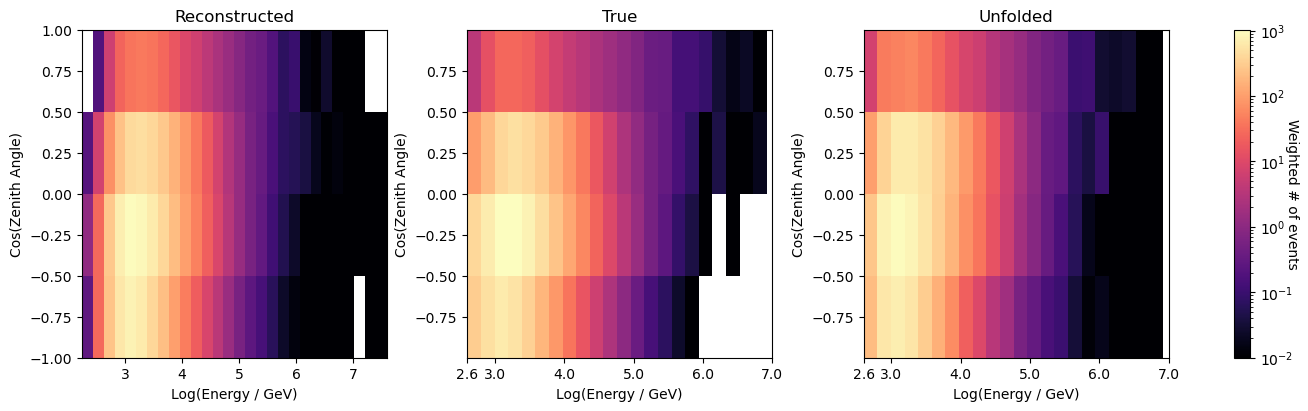

In [ ]:
X_recon, Y_recon = np.meshgrid(xedges_recon, yedges_recon)
X_true, Y_true = np.meshgrid(xedges_true, yedges_true)
tot_min = np.min([np.min(i) for i in (recon_binned, true_binned, final_unfolded)])
tot_max = np.max([np.max(i) for i in (recon_binned, true_binned, final_unfolded)])
fig, ax = plt.subplots(1, 3, layout = 'constrained')
fig.set_figheight(4)
fig.set_figwidth(13)

ax[0].pcolormesh(X_recon, Y_recon, recon_binned.T, cmap = 'magma', norm=LogNorm(vmin=.01, vmax=tot_max))
#ax[0].set_xticks(np.arange(round(min(recon_energy), 0), max(recon_energy), 1))
ax[0].set_title('Reconstructed')
ax[0].set_xlabel('Log(Energy / GeV)')
ax[0].set_ylabel('Cos(Zenith Angle)')
#ax[0].set_xticks([2.6, 3, 4, 5, 6, 7])
# ax[0].set_yticks([-1, .2, .6, 1])

im = ax[1].pcolormesh(X_true, Y_true, true_binned.T, cmap = 'magma', norm=LogNorm(vmin=.01, vmax=tot_max))
ax[1].set_title('True')
ax[1].set_xlabel('Log(Energy / GeV)')
ax[1].set_ylabel('Cos(Zenith Angle)')
ax[1].set_xticks([2.6, 3, 4, 5, 6, 7])
# ax[1].set_yticks([-1, .2, .6, 1])

ax[2].pcolormesh(X_true, Y_true, final_unfolded.T, cmap = 'magma', norm=LogNorm(vmin=.01, vmax=tot_max))
ax[2].set_title('Unfolded')
ax[2].set_xlabel('Log(Energy / GeV)')
ax[2].set_ylabel('Cos(Zenith Angle)')
ax[2].set_xticks([2.6, 3, 4, 5, 6, 7])
# ax[2].set_yticks([-1, .2, .6, 1])

cbar = fig.colorbar(im, ax=ax, shrink = 1)
cbar.set_label('Weighted # of events', rotation=270)

In [9]:
print(np.sum(np.power(true_binned - final_unfolded, 2) / true_binned)) #49.856478
print(22 * 4)

inf
88


/tmp/ipykernel_247072/2186686106.py:1: RuntimeWarning: divide by zero encountered in divide
  print(np.sum(np.power(true_binned - final_unfolded, 2) / true_binned)) #49.856478


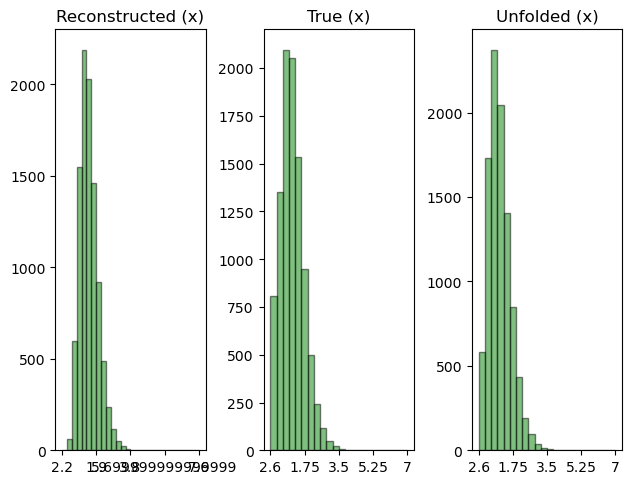

In [10]:
create_graphs1D([np.sum(recon_binned, axis=1), np.sum(true_binned, axis=1), np.sum(final_unfolded, axis=1)], ['Reconstructed (x)', 'True (x)', 'Unfolded (x)'], [[2.2, 7.6], [2.6, 7], [2.6, 7]], color = 'green')

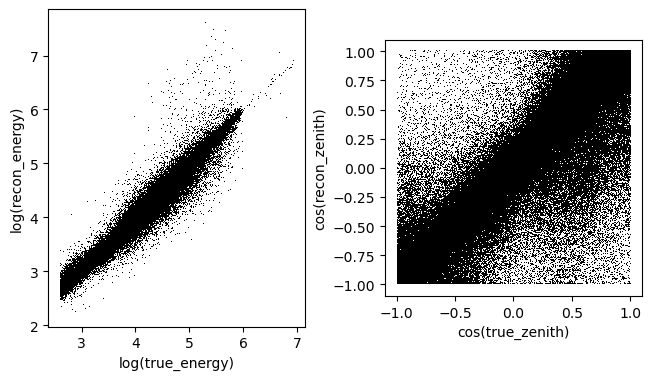

In [11]:
fig, ax = plt.subplots(1, 2, layout = 'constrained')
ax[0].set(adjustable='box', aspect='equal')
ax[0].plot(true_energy, recon_energy, 'k,')
ax[0].set_xlabel('log(true_energy)')
ax[0].set_ylabel('log(recon_energy)')
ax[1].set(adjustable='box', aspect='equal')
ax[1].plot(true_zenith, recon_zenith, 'k,')
ax[1].set_xlabel('cos(true_zenith)')
ax[1].set_ylabel('cos(recon_zenith)')
plt.show()

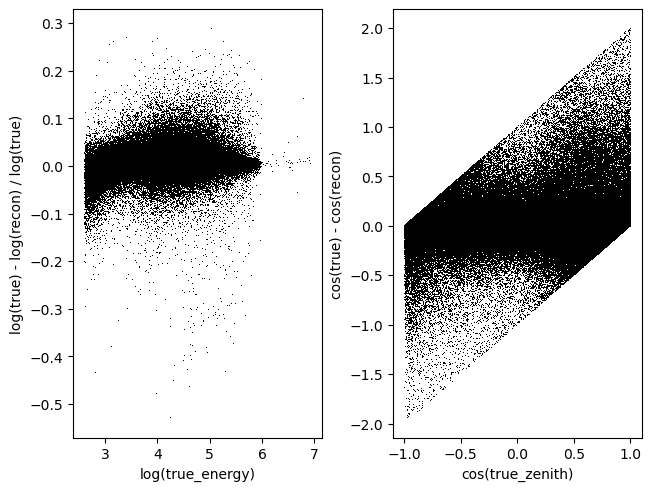

In [12]:
energy_resolution = (true_energy - recon_energy) / true_energy
zenith_resolution = true_zenith - recon_zenith 
fig, ax1 = plt.subplots(1, 2, layout = 'constrained')
#ax1[0].set(adjustable='box', aspect='equal')
ax1[0].plot(true_energy, energy_resolution, 'k,')
ax1[0].set_xlabel('log(true_energy)')
ax1[0].set_ylabel('log(true) - log(recon) / log(true)')
#ax1[1].set(adjustable='box', aspect='equal')
ax1[1].plot(true_zenith, zenith_resolution, 'k,')
ax1[1].set_xlabel('cos(true_zenith)')
ax1[1].set_ylabel('cos(true) - cos(recon)')
plt.show()